In [79]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('../data/processed/credit_data_with_risk.csv')
df['Risk'] = df['Risk'].map({'Good': 0, 'Bad': 1})

cat_cols = ['Saving accounts', 'Checking account', 'Housing', 'Purpose']
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

features = cat_cols + ['Age', 'Credit amount', 'Duration']
X = df[features]
y = df['Risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# GridSearchCV for Logistic Regression

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

params_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear']
}

lr = LogisticRegression()
grid_lr = GridSearchCV(lr, params_lr, cv=5, scoring='roc_auc')
grid_lr.fit(X_train, y_train)

print("Best Params (LogReg):", grid_lr.best_params_)
print("Best Score (LogReg):", grid_lr.best_score_)

Best Params (LogReg): {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score (LogReg): 0.7590526315789475


# GridSearchCV for Decision Tree

In [81]:
from sklearn.tree import DecisionTreeClassifier

params_dt = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier()
grid_dt = GridSearchCV(dt, params_dt, cv=5, scoring='roc_auc')
grid_dt.fit(X_train, y_train)

print("Best Params (Tree):", grid_dt.best_params_)


Best Params (Tree): {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}


# Evaluation (Confusion Matrix & ROC)

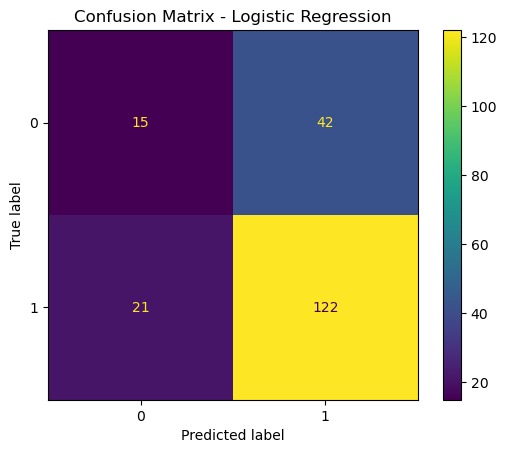

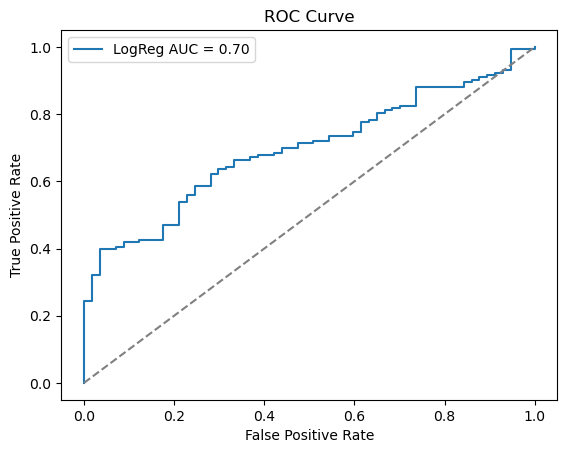

In [82]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Best model from GridSearch
best_model = grid_lr.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label='LogReg AUC = {:.2f}'.format(roc_auc_score(y_test, y_proba)))
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Saving Best Model

In [83]:
import joblib
joblib.dump(best_model, '../models/logistic_model_tuned.pkl')

['../models/logistic_model_tuned.pkl']

In [84]:
import os

# Always save to project-root level /models directory
output_path = os.path.abspath(os.path.join(os.getcwd(), "../models"))
os.makedirs(output_path, exist_ok=True)

# Decision Tree GridSearch CV

In [85]:
from sklearn.tree import DecisionTreeClassifier

params_dt = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier()
grid_dt = GridSearchCV(dt, params_dt, cv=5, scoring='roc_auc')
grid_dt.fit(X_train, y_train)

print("Best Decision Tree Params:", grid_dt.best_params_)

Best Decision Tree Params: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}


# Evaluating the best Decision Tree Model

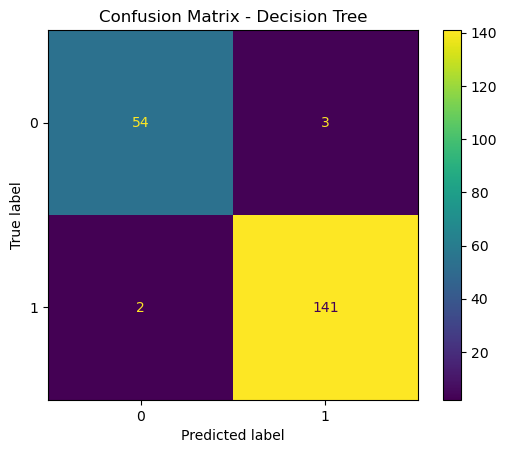

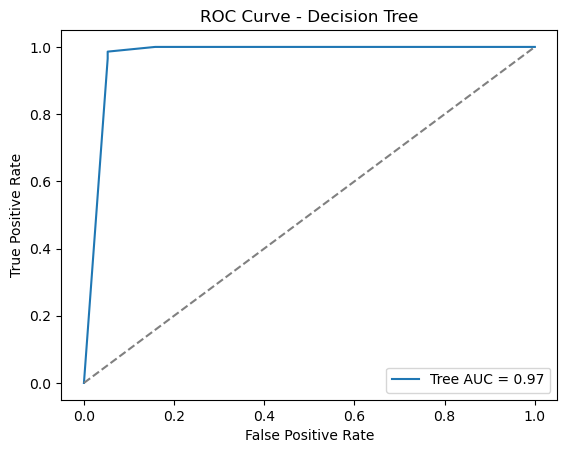

In [86]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report

best_tree = grid_dt.best_estimator_
y_pred_dt = best_tree.predict(X_test)
y_proba_dt = best_tree.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
ConfusionMatrixDisplay(confusion_matrix=cm_dt).plot()
plt.title("Confusion Matrix - Decision Tree")
plt.savefig(os.path.join(output_path, "confusion_matrix_tree.png"))
plt.show()

# ROC Curve
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)

plt.plot(fpr_dt, tpr_dt, label='Tree AUC = {:.2f}'.format(roc_auc_score(y_test, y_proba_dt)))
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title("ROC Curve - Decision Tree")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig(os.path.join(output_path, "roc_curve_tree.png"))
plt.show()


# Saving the Model

In [87]:
import joblib
joblib.dump(best_tree, os.path.join(output_path, "tree_model_tuned.pkl"))

['b:\\credit-risk-xai\\models\\tree_model_tuned.pkl']

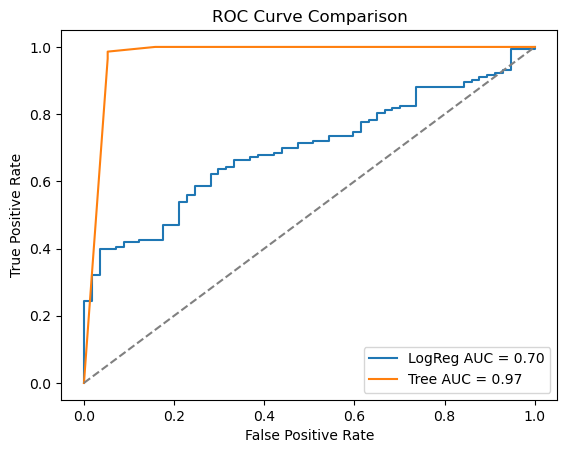

In [88]:
# ROC curve for logistic regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, grid_lr.best_estimator_.predict_proba(X_test)[:, 1])
auc_lr = roc_auc_score(y_test, grid_lr.best_estimator_.predict_proba(X_test)[:, 1])
auc_dt = roc_auc_score(y_test, y_proba_dt)

plt.plot(fpr_lr, tpr_lr, label='LogReg AUC = {:.2f}'.format(auc_lr))
plt.plot(fpr_dt, tpr_dt, label='Tree AUC = {:.2f}'.format(auc_dt))
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig(os.path.join(output_path, "roc_curve_comparison.png"))
plt.show()

# Comparison Plot (AUC)

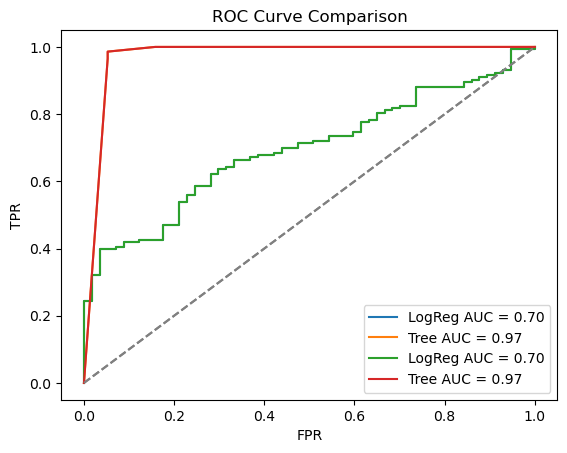

In [90]:
# Combine ROC Curves: Logistic vs Tree
fpr_lr, tpr_lr, _ = roc_curve(y_test, grid_lr.best_estimator_.predict_proba(X_test)[:, 1])
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)

plt.plot(fpr_lr, tpr_lr, label='LogReg AUC = {:.2f}'.format(roc_auc_score(y_test, grid_lr.best_estimator_.predict_proba(X_test)[:, 1])))
plt.plot(fpr_dt, tpr_dt, label='Tree AUC = {:.2f}'.format(roc_auc_score(y_test, y_proba_dt)))
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title("ROC Curve Comparison")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.savefig("../models/roc_curve_comparison.png")
plt.show()

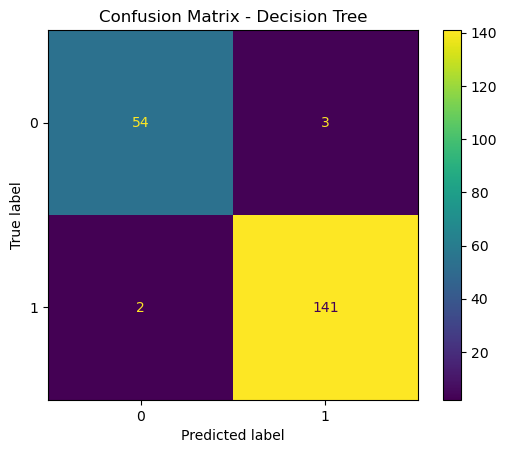

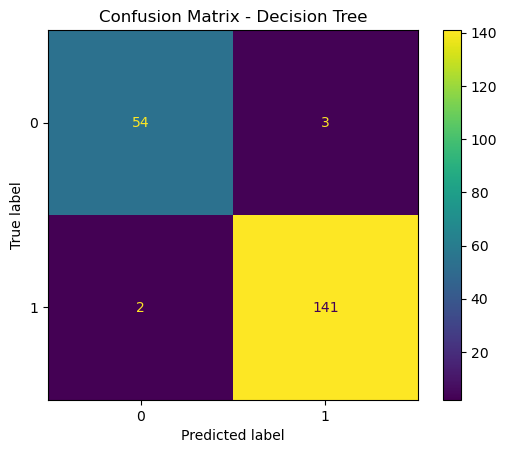

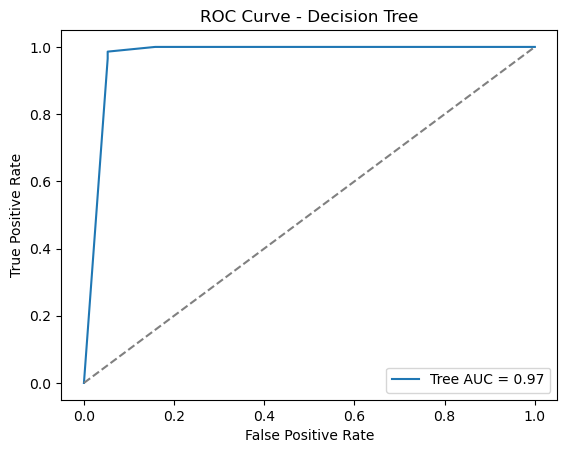

In [92]:
import os
os.makedirs("../models", exist_ok=True)

# Confusion Matrix - Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)
ConfusionMatrixDisplay(confusion_matrix=cm_dt).plot()
plt.title("Confusion Matrix - Decision Tree")
plt.savefig("../models/confusion_matrix_tree.png")
plt.show()

# ROC - Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
plt.plot(fpr_dt, tpr_dt, label='Tree AUC = {:.2f}'.format(roc_auc_score(y_test, y_proba_dt)))
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title("ROC Curve - Decision Tree")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig("../models/roc_curve_tree.png")
plt.show()

In [93]:
import joblib
joblib.dump(best_tree, "../models/tree_model_tuned.pkl")

['../models/tree_model_tuned.pkl']

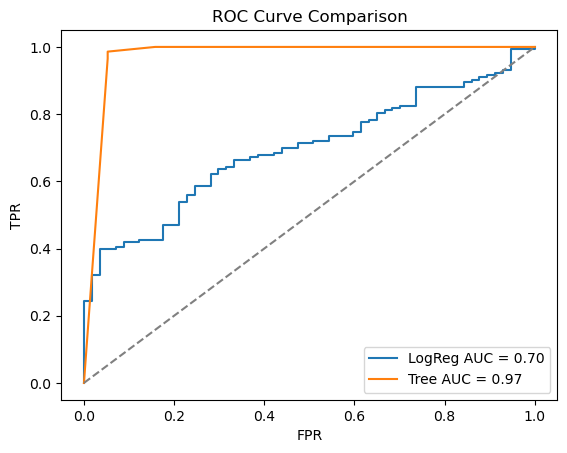

In [94]:
# ROC Curve Comparison
fpr_lr, tpr_lr, _ = roc_curve(y_test, grid_lr.best_estimator_.predict_proba(X_test)[:, 1])

plt.plot(fpr_lr, tpr_lr, label='LogReg AUC = {:.2f}'.format(roc_auc_score(y_test, grid_lr.best_estimator_.predict_proba(X_test)[:, 1])))
plt.plot(fpr_dt, tpr_dt, label='Tree AUC = {:.2f}'.format(roc_auc_score(y_test, y_proba_dt)))
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title("ROC Curve Comparison")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.savefig("../models/roc_curve_comparison.png")
plt.show()


# SHAP installation

In [95]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [96]:
import shap
import joblib
import pandas as pd

import os
os.makedirs("models", exist_ok=True)

# Load data
df = pd.read_csv("../data/processed/credit_data_with_risk.csv")
df['Risk'] = df['Risk'].map({'Good': 0, 'Bad': 1})

cat_cols = ['Saving accounts', 'Checking account', 'Housing', 'Purpose']
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

features = cat_cols + ['Age', 'Credit amount', 'Duration']
X = df[features]

# Load model
logreg_model = joblib.load("../models/logistic_model_tuned.pkl")

# SHAP Explainer
explainer = shap.Explainer(logreg_model, X)
shap_values = explainer(X)

# Save summary plot
import matplotlib.pyplot as plt
output_path = "../models/"
shap.plots.beeswarm(shap_values, max_display=10, show=False)
plt.savefig(f"{output_path}/shap_beeswarm_logreg.png")
plt.close()

# Save one sample explanation
shap.plots.waterfall(shap_values[0], show=False)
plt.savefig(f"{output_path}/shap_waterfall_logreg_sample0.png")
plt.close()

In [103]:
import shap
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Set output path
output_path = "../models"
os.makedirs(output_path, exist_ok=True)

# Load processed data
df = pd.read_csv("../data/processed/credit_data_with_risk.csv")
df['Risk'] = df['Risk'].map({'Good': 0, 'Bad': 1})

# Encode categorical variables
from sklearn.preprocessing import LabelEncoder
cat_cols = ['Saving accounts', 'Checking account', 'Housing', 'Purpose']
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

features = cat_cols + ['Age', 'Credit amount', 'Duration']
X = df[features]
y = df['Risk']

# Load model
tree_model = joblib.load("../models/tree_model_tuned.pkl")

# Use SHAP's modern explainer
explainer = shap.Explainer(tree_model.predict, X)
shap_values = explainer(X)

# Summary plot
shap.plots.beeswarm(shap_values, show=False)
plt.savefig(os.path.join(output_path, "shap_beeswarm_tree.png"))
plt.close()

# Waterfall plot for 1st instance
shap.plots.waterfall(shap_values[0], show=False)
plt.savefig(os.path.join(output_path, "shap_waterfall_tree_sample0.png"))
plt.close()
